# Tayafa Zaman; TXST ID: A05296103 [Part 1]

In [1]:
# import necessary libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Problem 1(A)
The plot of META stock returns from the beginning of 2018 through the end of August 2023 is given in the following figure.

[*********************100%%**********************]  1 of 1 completed


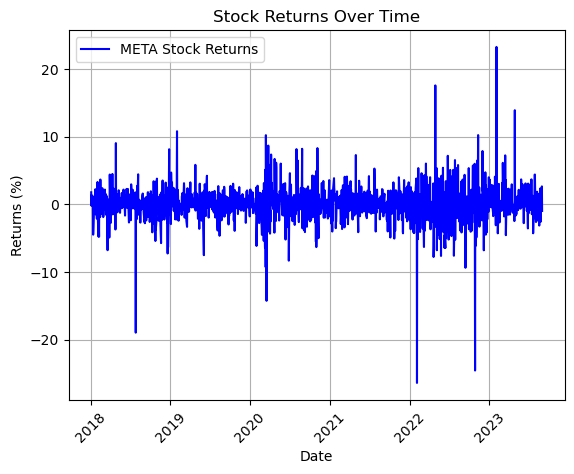

In [2]:
start_date = '2018-01-01'
end_date = '2023-08-31'

stock_data = yf.download('META', start=pd.to_datetime(start_date), end=pd.to_datetime(end_date))
stock_returns = stock_data['Adj Close'].pct_change()
plt.plot(stock_returns.index, stock_returns*100, label='META Stock Returns', color='blue')
plt.title('Stock Returns Over Time')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Returns (%)')
plt.grid()
plt.legend()
plt.show()

## (a)
Now we use event study method to discuss the impact of announcement: 'Threads is launched' on July 5th, 2023. The steps are explained the comments in the script. First we work on the event and estimation windows:

#### Please note that here we are dealing with only one stock ('META'). So, there is no need to find Average Abnormal Return (AAR) and Cumulative Average Abnormal Return (CAAR). We will only report Abnormal Return (AR) and Cumulative Abnormal Return (CAR).

In [3]:
event_date_str = '2023-07-05'
stock_symbol = "META"
mkt_symbol = "^GSPC"

bef_event = 4 # event window starts 5 days before event
aft_event = 4 # event window ends 5 days after event
window_offset = 15 # gap between event and estimation windows
window_size = 60  # estimation window size

print('Event Window: '+str(bef_event)+' trading days before and '+\
      str(aft_event)+' trading days after event day including event day.', )
print('Estimation Window: '+str(window_size)+' trading days with '+\
      str(window_offset)+' trading days offset between event and estimation window')

# Following days are use to pull data of stocks.
# We collect more data then needed and select only relavant portion later
tot_days_before = round(2*(window_offset + window_size), 0)
tot_days_after = round(2*(aft_event), 0)

print('Event Date: '+event_date_str+'\n\n')
event_date = pd.to_datetime(event_date_str)

data_start_date = event_date - pd.DateOffset(days=tot_days_before)
data_end_date = event_date + pd.DateOffset(days=tot_days_after)

mkt_data = yf.download(mkt_symbol, start=data_start_date, end=data_end_date)
stock_data = yf.download(stock_symbol, start=data_start_date, end=data_end_date)

stock_returns = stock_data['Adj Close'].pct_change()
mkt_returns = mkt_data['Adj Close'].pct_change()

# Ensure that stock returns available for event date
if not event_date_str in stock_returns.index:
    print('Event date not a work day')
    
# We find the window by taking number of positions not absolute date.
# this is because the trading may be closed for some days.
# So we calculating the windows by number of 'trading days' not 'calender days'
event_pos = stock_returns.index.get_loc(event_date_str)
event_start_pos = event_pos - bef_event
event_end_pos = event_pos + aft_event
est_start_pos = event_pos - (bef_event+window_offset+window_size)
est_end_pos = event_pos - (bef_event+window_offset)

print('\n')
print('Event Window start date: ', stock_returns.index[event_start_pos])
print('Event Window end date: ', stock_returns.index[event_end_pos])
print('\n')
print('Estimation Window start date: ', stock_returns.index[est_start_pos])
print('Estimation Window end date: ', stock_returns.index[est_end_pos])
print('\n')

# Returns for the windows
estimation_window_stock = stock_returns.iloc[est_start_pos:est_end_pos]
estimation_window_mkt = mkt_returns.iloc[est_start_pos:est_end_pos]
event_window_stock = stock_returns.iloc[event_start_pos:event_end_pos+1]
event_window_mkt = mkt_returns.iloc[event_start_pos:event_end_pos+1]

print('Estimation Window Length: ', len(estimation_window_stock))
print('Event Window Length: ', len(event_window_stock))

Event Window: 4 trading days before and 4 trading days after event day including event day.
Estimation Window: 60 trading days with 15 trading days offset between event and estimation window
Event Date: 2023-07-05


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Event Window start date:  2023-06-28 00:00:00
Event Window end date:  2023-07-11 00:00:00


Estimation Window start date:  2023-03-10 00:00:00
Estimation Window end date:  2023-06-06 00:00:00


Estimation Window Length:  60
Event Window Length:  9


Now we run a regression model to fit a line using returns from our stock and the market in the estimation period. We also calculate the standard error in this period to be used lated for t-statistics. For this we use OLS from statsmodels

In [4]:
import statsmodels.api as sm
X_train_const = sm.add_constant(estimation_window_mkt)
y_train = estimation_window_stock
# Fit the model
model_stats = sm.OLS(y_train, X_train_const).fit()
# Get the summary, which includes standard errors, t-values, and p-values
# print(model_stats.summary())

my_beta1 = model_stats.params['const']
my_beta2 = model_stats.params['Adj Close']
err = estimation_window_stock - (my_beta1+my_beta2*estimation_window_mkt)
# my_se = model_stats.bse['Adj Close']
my_se = np.std(err)

print('alpha = ', my_beta1)
print('beta = ', my_beta2)
print('standard error = ', my_se)
print('R-squared value: ',model_stats.rsquared*100, '%')

alpha =  0.004283606647800164
beta =  1.8256737096450277
standard error =  0.018687736418672683
R-squared value:  41.98135075517544 %


We calculate the expected returns and look the event window returns to get an idea

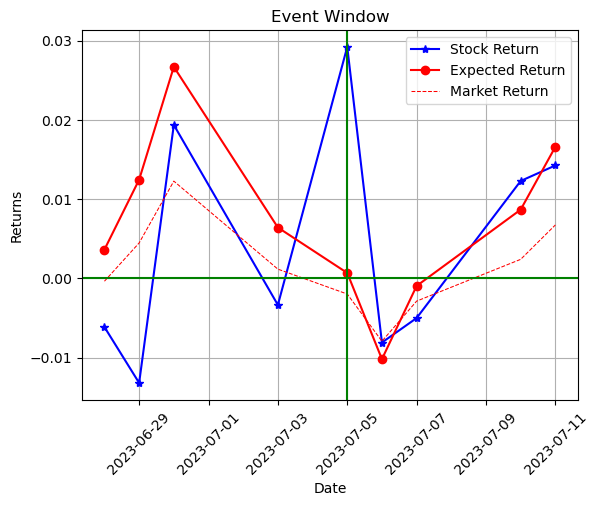

In [5]:
# Use the parameters from regression to find expected returns
expected_returns = my_beta1 + my_beta2*event_window_mkt
abnormal_returns = event_window_stock - expected_returns

plt.plot(event_window_stock.index, event_window_stock,
         '-*', label='Stock Return', color='blue')
plt.plot(expected_returns.index, expected_returns,
         '-o', label='Expected Return', color='red')
plt.plot(event_window_mkt.index, event_window_mkt, '--',
         label='Market Return', color='red', linewidth=0.75)
plt.axhline(color='green', linestyle='-', linewidth=1.5)
plt.axvline(expected_returns.index[expected_returns.index.get_loc(event_date_str)],
            color='green', linestyle='-', linewidth=1.5)
plt.title('Event Window')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Returns')
plt.grid()
plt.legend()
plt.show()

Now we calculate the results

In [6]:
# Calculate cumulative abnormal return (CAR)
CAR = abnormal_returns.sum()
# t-statistics
# For 2-tailed 5% confidence, we use sritical value of ~1.96
tAR = abnormal_returns/my_se
tCAR = CAR/(my_se*np.sqrt(len(event_window_stock)))

print('CAR: ', CAR)
print('tCAR', tCAR)
print('AR: \n',abnormal_returns)
print('tAR:\n', tAR)

CAR:  -0.02467568162176868
tCAR -0.4401403692229747
AR: 
 Date
2023-06-28   -0.009768
2023-06-29   -0.025630
2023-06-30   -0.007324
2023-07-03   -0.009766
2023-07-05    0.028504
2023-07-06    0.002095
2023-07-07   -0.004053
2023-07-10    0.003614
2023-07-11   -0.002346
Name: Adj Close, dtype: float64
tAR:
 Date
2023-06-28   -0.522719
2023-06-29   -1.371511
2023-06-30   -0.391929
2023-07-03   -0.522596
2023-07-05    1.525262
2023-07-06    0.112118
2023-07-07   -0.216881
2023-07-10    0.193363
2023-07-11   -0.125527
Name: Adj Close, dtype: float64


From the plot, we can see that there was a positive abnormal return in the stock on the event day. However, the four days preceding the event experienced consistent negative abnormal returns from the stock. The event caused stock returns to increase compared to previous days as announcing a new product caused stock price to increase. According to the T-statistics, none of the abnormal returns and CAR were significant. The market absorbed the effect immediately.

Now we wrap the Event Study Methodology in a function to use for later problems.

In [7]:
def ESM(stock_symbol, event_date_str, bef_event, aft_event, window_offset, window_size):   
    #event_date_str = '2021-10-28'
    #stock_symbol = "META"
    mkt_symbol = "^GSPC"
    #bef_event = 5
    #aft_event = 5
    #window_offset = 10
    #window_size = 90
    print('Event Window: '+str(bef_event)+' trading days before and '+\
          str(aft_event)+' trading days after event day including event day.', )
    print('Estimation Window: '+str(window_size)+' trading days with '+\
          str(window_offset)+' trading days offset between event and estimation window')
    tot_days_before = round(2*(window_offset + window_size), 0)
    tot_days_after = round(2*(aft_event), 0)
    print('Event Date: '+event_date_str+'\n\n')
    event_date = pd.to_datetime(event_date_str)
    data_start_date = event_date - pd.DateOffset(days=tot_days_before)
    data_end_date = event_date + pd.DateOffset(days=tot_days_after)
    mkt_data = yf.download(mkt_symbol, start=data_start_date, end=data_end_date)
    stock_data = yf.download(stock_symbol, start=data_start_date, end=data_end_date)
    stock_returns = stock_data['Adj Close'].pct_change()
    mkt_returns = mkt_data['Adj Close'].pct_change()
    if not event_date_str in stock_returns.index:
        print('Event date not a work day')
        return
    event_pos = stock_returns.index.get_loc(event_date_str)
    event_start_pos = event_pos - bef_event
    event_end_pos = event_pos + aft_event
    est_start_pos = event_pos - (bef_event+window_offset+window_size)
    est_end_pos = event_pos - (bef_event+window_offset)
    print('\n')
    print('Event Window start date: ', stock_returns.index[event_start_pos])
    print('Event Window end date: ', stock_returns.index[event_end_pos])
    print('\n')
    print('Estimation Window start date: ', stock_returns.index[est_start_pos])
    print('Estimation Window end date: ', stock_returns.index[est_end_pos])
    print('\n')
    estimation_window_stock = stock_returns.iloc[est_start_pos:est_end_pos]
    estimation_window_mkt = mkt_returns.iloc[est_start_pos:est_end_pos]
    event_window_stock = stock_returns.iloc[event_start_pos:event_end_pos+1]
    event_window_mkt = mkt_returns.iloc[event_start_pos:event_end_pos+1]
    print('Estimatin Window Length: ', len(estimation_window_stock))
    print('Event Window Length: ', len(event_window_stock))
    import statsmodels.api as sm
    X_train_const = sm.add_constant(estimation_window_mkt)
    y_train = estimation_window_stock
    model_stats = sm.OLS(y_train, X_train_const).fit()
    my_beta1 = model_stats.params['const']
    my_beta2 = model_stats.params['Adj Close']
    err = estimation_window_stock - (my_beta1+my_beta2*estimation_window_mkt)
    my_se = np.std(err)
    print('\nalpha = ', my_beta1)
    print('beta = ', my_beta2)
    print('standard error = ', my_se)
    print('R-squared value: ',model_stats.rsquared*100, '%')
    expected_returns = my_beta1 + my_beta2*event_window_mkt
    abnormal_returns = event_window_stock - expected_returns
    plt.plot(event_window_stock.index, event_window_stock,
             '-*', label='Stock Return', color='blue')
    plt.plot(expected_returns.index, expected_returns,
             '-o', label='Expected Return', color='red')
    plt.plot(event_window_mkt.index, event_window_mkt, '--',
             label='Market Return', color='red', linewidth=0.75)
    plt.axhline(color='green', linestyle='-', linewidth=1.5)
    plt.axvline(expected_returns.index[expected_returns.index.get_loc(event_date_str)],
                color='green', linestyle='-', linewidth=1.5)
    plt.title('Event Window')
    plt.xlabel('Date')
    plt.xticks(rotation=45)
    plt.ylabel('Returns')
    plt.grid()
    plt.legend()
    plt.show()    
    CAR = abnormal_returns.sum()
    tAR = abnormal_returns/my_se
    tCAR = CAR/(my_se*np.sqrt(len(event_window_stock)))
    print('CAR: ', CAR)
    print('tCAR', tCAR)
    print('AR: \n',abnormal_returns)
    print('tAR:\n', tAR)
    return

## (b)
Now we use event study method to discuss the impact of announcement: 'Twitter threatens legal action over Threads' on July 6th, 2023.

Event Window: 5 trading days before and 5 trading days after event day including event day.
Estimation Window: 60 trading days with 15 trading days offset between event and estimation window
Event Date: 2023-07-06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Event Window start date:  2023-06-28 00:00:00
Event Window end date:  2023-07-13 00:00:00


Estimation Window start date:  2023-03-10 00:00:00
Estimation Window end date:  2023-06-06 00:00:00


Estimatin Window Length:  60
Event Window Length:  11

alpha =  0.004283606647800164
beta =  1.8256737096450277
standard error =  0.018687736418672683
R-squared value:  41.98135075517544 %


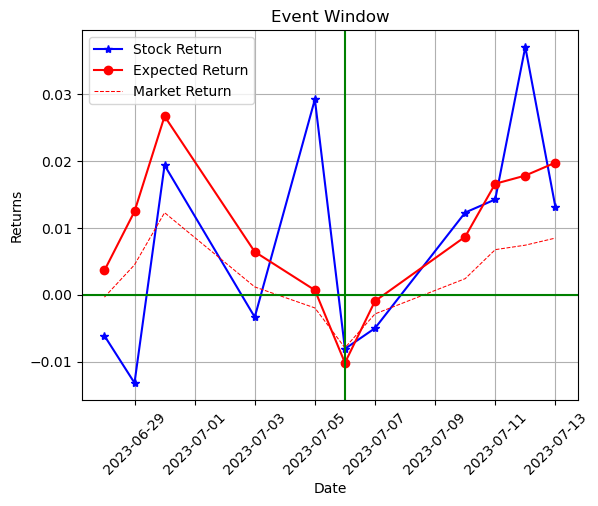

CAR:  -0.01203561274653948
tCAR -0.1941847691302216
AR: 
 Date
2023-06-28   -0.009768
2023-06-29   -0.025630
2023-06-30   -0.007324
2023-07-03   -0.009766
2023-07-05    0.028504
2023-07-06    0.002095
2023-07-07   -0.004053
2023-07-10    0.003614
2023-07-11   -0.002346
2023-07-12    0.019230
2023-07-13   -0.006590
Name: Adj Close, dtype: float64
tAR:
 Date
2023-06-28   -0.522719
2023-06-29   -1.371511
2023-06-30   -0.391929
2023-07-03   -0.522596
2023-07-05    1.525262
2023-07-06    0.112118
2023-07-07   -0.216881
2023-07-10    0.193363
2023-07-11   -0.125527
2023-07-12    1.029035
2023-07-13   -0.352652
Name: Adj Close, dtype: float64


In [8]:
ESM('META','2023-07-06', bef_event=5, aft_event=5, window_offset=15, window_size=60)

From the plot, we can see that 4 days after the event did not experience any abnormal returns followed by a positive abnormal return in the 5th day. However, there were some abnormal returns before the event, which may indicate event anticipation and other events (like 'threads is launched'). According to the T-statistics, none of the abnormal returns and CAR were significant. This event had no impact on stock whatsoever.

## (c)
Now we use event study method to discuss the impact of announcement: 'Meta cuts 11,000 jobs' on Nov 9th, 2022.

Event Window: 4 trading days before and 4 trading days after event day including event day.
Estimation Window: 120 trading days with 15 trading days offset between event and estimation window
Event Date: 2022-11-09


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Event Window start date:  2022-11-03 00:00:00
Event Window end date:  2022-11-15 00:00:00


Estimation Window start date:  2022-04-22 00:00:00
Estimation Window end date:  2022-10-13 00:00:00


Estimatin Window Length:  120
Event Window Length:  9

alpha =  -1.7938847362794844e-05
beta =  1.6261599275625251
standard error =  0.02470946213628423
R-squared value:  53.805190370311074 %


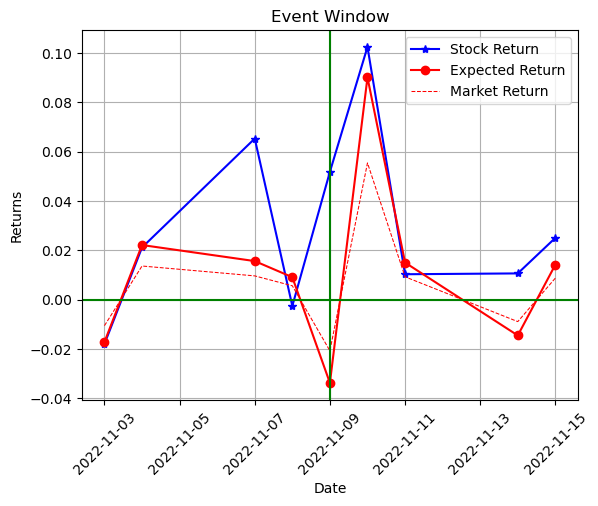

CAR:  0.16560316265564046
tCAR 2.2340046867101844
AR: 
 Date
2022-11-03   -0.000771
2022-11-04   -0.000983
2022-11-07    0.049700
2022-11-08   -0.011670
2022-11-09    0.085636
2022-11-10    0.012366
2022-11-11   -0.004729
2022-11-14    0.025167
2022-11-15    0.010888
Name: Adj Close, dtype: float64
tAR:
 Date
2022-11-03   -0.031187
2022-11-04   -0.039796
2022-11-07    2.011360
2022-11-08   -0.472285
2022-11-09    3.465704
2022-11-10    0.500455
2022-11-11   -0.191395
2022-11-14    1.018499
2022-11-15    0.440658
Name: Adj Close, dtype: float64


In [9]:
ESM('META','2022-11-09', bef_event=4, aft_event=4, window_offset=15, window_size=120)

From the plot, we can see that there was a huge positive abnormal return on the event day, which is also significant according to t-statistics. META Laid-off employees to restructure the company which indicated a better perfomance in the future. This caused the company to gain popularity and increased stock price. Additionally, there was a significant positive abnormal return 2 days before the event, which may indicate anticipation or inside information about the event. The CAR value is also significant according to t-statistics which means the event had overall significant impact on the market. However, the market absorbed the impact quickly and stock returned to normal in the days following the event.

## (d)
Now we use event study method to discuss the impact of announcement: 'Meta warns it could remove news from its platform if congress signs a bill that would make it easier for news organizations to bargain collectively' on Dec 05, 2022.

Event Window: 4 trading days before and 4 trading days after event day including event day.
Estimation Window: 120 trading days with 15 trading days offset between event and estimation window
Event Date: 2022-12-05


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Event Window start date:  2022-11-29 00:00:00
Event Window end date:  2022-12-09 00:00:00


Estimation Window start date:  2022-05-17 00:00:00
Estimation Window end date:  2022-11-07 00:00:00


Estimatin Window Length:  120
Event Window Length:  9

alpha =  -0.005142328120691554
beta =  1.5576379470900443
standard error =  0.030606835786493754
R-squared value:  39.07712658681209 %


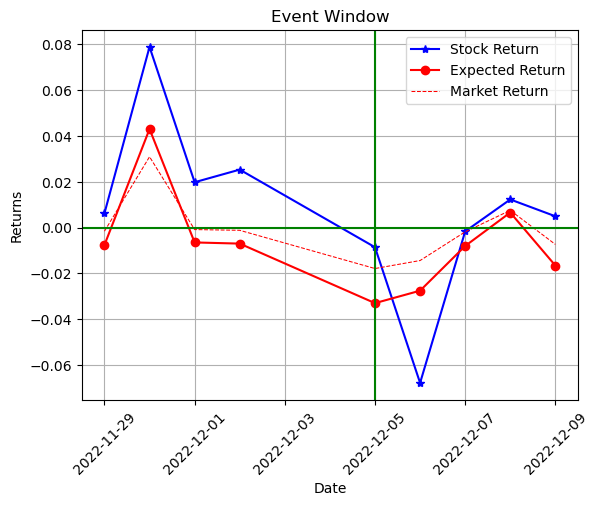

CAR:  0.12612944012692365
tCAR 1.373652180259922
AR: 
 Date
2022-11-29    0.013873
2022-11-30    0.035870
2022-12-01    0.026308
2022-12-02    0.032327
2022-12-05    0.024431
2022-12-06   -0.040304
2022-12-07    0.006378
2022-12-08    0.005714
2022-12-09    0.021533
Name: Adj Close, dtype: float64
tAR:
 Date
2022-11-29    0.453266
2022-11-30    1.171950
2022-12-01    0.859531
2022-12-02    1.056200
2022-12-05    0.798232
2022-12-06   -1.316844
2022-12-07    0.208394
2022-12-08    0.186703
2022-12-09    0.703524
Name: Adj Close, dtype: float64


In [10]:
ESM('META','2022-12-05', bef_event=4, aft_event=4, window_offset=15, window_size=120)

From the plot, we can see that stock returns were higher than expected before and during the event but lower in the day after the event. This may indicate that META's warning to federal govt. action impacted its stock price negetively. Although, none of the t-statistics show any significane, it had a small impact. Afterwards, the abnormal return became small and the market adjusted occordingly in a very small time.

## (e)
Now we use event study method to discuss the impact of announcement: 'Facebook changes its name to Meta Platforms' on Oct 28, 2021.

Event Window: 10 trading days before and 5 trading days after event day including event day.
Estimation Window: 90 trading days with 15 trading days offset between event and estimation window
Event Date: 2021-10-28


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Event Window start date:  2021-10-14 00:00:00
Event Window end date:  2021-11-04 00:00:00


Estimation Window start date:  2021-05-17 00:00:00
Estimation Window end date:  2021-09-23 00:00:00


Estimatin Window Length:  90
Event Window Length:  16

alpha =  0.00034580122437283755
beta =  1.1535317719405236
standard error =  0.013142230365061184
R-squared value:  21.979064868437202 %


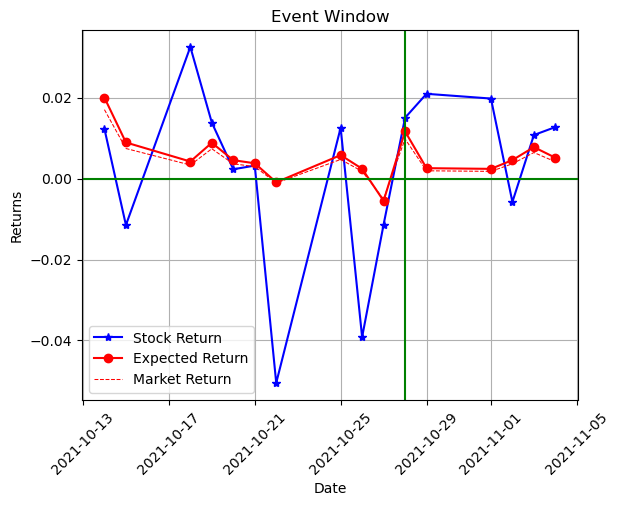

CAR:  -0.04867300438046753
tCAR -0.925889347326186
AR: 
 Date
2021-10-14   -0.007734
2021-10-15   -0.020427
2021-10-18    0.028339
2021-10-19    0.004992
2021-10-20   -0.002249
2021-10-21   -0.000574
2021-10-22   -0.049623
2021-10-25    0.006746
2021-10-26   -0.041631
2021-10-27   -0.005886
2021-10-28    0.003369
2021-10-29    0.018389
2021-11-01    0.017388
2021-11-02   -0.010349
2021-11-03    0.002991
2021-11-04    0.007586
Name: Adj Close, dtype: float64
tAR:
 Date
2021-10-14   -0.588510
2021-10-15   -1.554281
2021-10-18    2.156343
2021-10-19    0.379863
2021-10-20   -0.171109
2021-10-21   -0.043655
2021-10-22   -3.775876
2021-10-25    0.513306
2021-10-26   -3.167717
2021-10-27   -0.447887
2021-10-28    0.256375
2021-10-29    1.399212
2021-11-01    1.323064
2021-11-02   -0.787478
2021-11-03    0.227586
2021-11-04    0.577207
Name: Adj Close, dtype: float64


In [11]:
ESM('META','2021-10-28', bef_event=10, aft_event=5, window_offset=15, window_size=90)

From the plot, we can see that there were some significant abnormal returns before the event. The abnormal returns before the event may indicate that there was a significant event in the industry which only affects the industry stocks but does not affect the market stocks as a whole. Alternatively, it may be due to anticipation of the event. Two days following the event, we can see a positive abnormal return (not significant, though), which means the announcement of META caused the stock price to increase. The CAR values are not significant as well. Overall, the event caused significant abnormality before the event

### Analysis
According to our analysis, main problems arise when using the event study:

Firstly, the event study relies on the estimation period to calculate the intercept parameter, slope parameter, and standard error. However, the estimation period itself may have significant abnormalities due to other events, which we may not be aware of. This can severely bias the estimations, which will eventually be used in the event window.

Secondly, stock returns may not only depend on the market return but also on the industry return. There might be events that only affect industry stocks but not the market as a whole. This can result in incorrect expected returns for the stock.

Thirdly, simple regression may not capture everything needed to estimate expected stock returns. We can see from the analysis that the $R^2$ values are very poor, around 40%. This indicates that stock returns are not well-represented by market returns.

## Problem 1(B)
Here we discuss three events invovling Mark Zuckerberg as an individual. These are given below:

## (a)
Now we use event study method to discuss the impact of announcement: 'Mark Zuckerberg celebrates 20th anniversary with wife Priscilla Chan: ‘What a wild ride’' on Nov 15, 2023.

Event Window: 3 trading days before and 3 trading days after event day including event day.
Estimation Window: 90 trading days with 15 trading days offset between event and estimation window
Event Date: 2023-11-15


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Event Window start date:  2023-11-10 00:00:00
Event Window end date:  2023-11-20 00:00:00


Estimation Window start date:  2023-06-13 00:00:00
Estimation Window end date:  2023-10-20 00:00:00


Estimatin Window Length:  90
Event Window Length:  7

alpha =  0.0020107108495723623
beta =  1.8219561191498377
standard error =  0.013722956587727066
R-squared value:  46.62077777942596 %


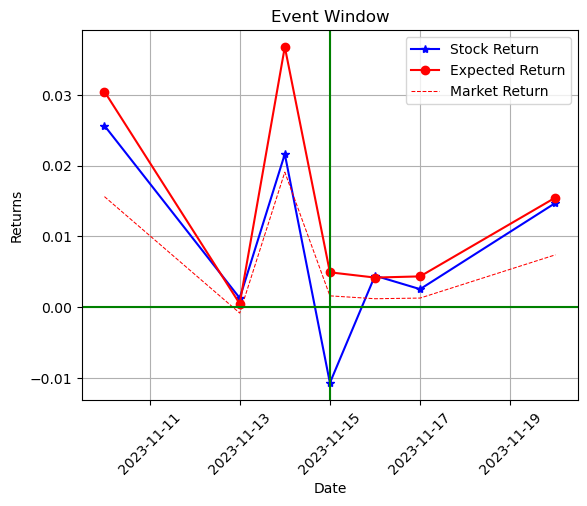

CAR:  -0.037085786347597356
tCAR -1.0214351115515756
AR: 
 Date
2023-11-10   -0.004820
2023-11-13    0.000790
2023-11-14   -0.015136
2023-11-15   -0.015625
2023-11-16    0.000269
2023-11-17   -0.001803
2023-11-20   -0.000761
Name: Adj Close, dtype: float64
tAR:
 Date
2023-11-10   -0.351218
2023-11-13    0.057545
2023-11-14   -1.102949
2023-11-15   -1.138590
2023-11-16    0.019583
2023-11-17   -0.131391
2023-11-20   -0.055442
Name: Adj Close, dtype: float64


In [12]:
ESM('META','2023-11-15', bef_event=3, aft_event=3, window_offset=15, window_size=90)

From the plot, we can see that the event had some positive impact the day before the event and some negative impact on the event day. However, they were not significant according to t-statistics. The TCAR is also not significant. This event of Mark Zuckerberg did not impact META stock.

## (b)
Now we use event study method to discuss the impact of announcement: 'Cambridge Analytica whistleblower' on Mar 17, 2018.

Event Window: 5 trading days before and 5 trading days after event day including event day.
Estimation Window: 90 trading days with 15 trading days offset between event and estimation window
Event Date: 2018-03-19


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Event Window start date:  2018-03-12 00:00:00
Event Window end date:  2018-03-26 00:00:00


Estimation Window start date:  2017-10-09 00:00:00
Estimation Window end date:  2018-02-16 00:00:00


Estimatin Window Length:  90
Event Window Length:  11

alpha =  -0.00030681485944626587
beta =  1.1534108381103323
standard error =  0.012845338208343361
R-squared value:  35.32333393798195 %


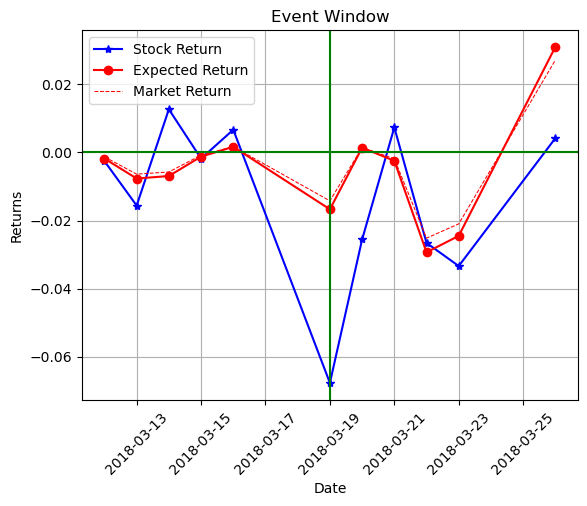

CAR:  -0.08571478474656273
tCAR -2.0119345695657445
AR: 
 Date
2018-03-12   -0.000761
2018-03-13   -0.007941
2018-03-14    0.019610
2018-03-15   -0.000583
2018-03-16    0.005032
2018-03-19   -0.051007
2018-03-20   -0.026959
2018-03-21    0.009808
2018-03-22    0.002764
2018-03-23   -0.008865
2018-03-26   -0.026813
Name: Adj Close, dtype: float64
tAR:
 Date
2018-03-12   -0.059255
2018-03-13   -0.618209
2018-03-14    1.526640
2018-03-15   -0.045381
2018-03-16    0.391729
2018-03-19   -3.970834
2018-03-20   -2.098712
2018-03-21    0.763553
2018-03-22    0.215179
2018-03-23   -0.690159
2018-03-26   -2.087383
Name: Adj Close, dtype: float64


In [13]:
ESM('META','2018-03-19', bef_event=5, aft_event=5, window_offset=15, window_size=90)

This event had a significant impact on stock returns. On the day of the event and afterward, the stock return faced significant abnormal returns. The days before the event were normal, which indicates that the event was a surprise. The market adjusted quickly after the event. The TCAR value is also significant.

## (c)
Now we use event study method to discuss the impact of announcement: 'Facebook founder Mark Zuckerberg pays visit to University of Michigan-Dearborn' on April 28, 2017.

Event Window: 6 trading days before and 3 trading days after event day including event day.
Estimation Window: 90 trading days with 15 trading days offset between event and estimation window
Event Date: 2017-04-28


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Event Window start date:  2017-04-20 00:00:00
Event Window end date:  2017-05-03 00:00:00


Estimation Window start date:  2016-11-16 00:00:00
Estimation Window end date:  2017-03-29 00:00:00


Estimatin Window Length:  90
Event Window Length:  10

alpha =  0.0012213334848583486
beta =  1.0724373376410075
standard error =  0.009066637847134244
R-squared value:  21.064945211921383 %


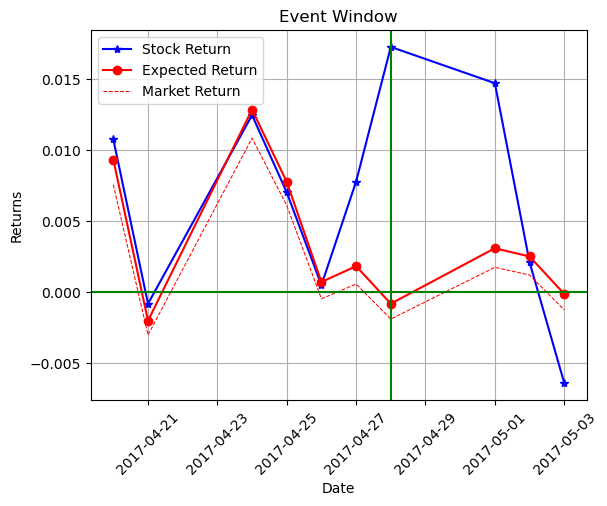

CAR:  0.030293799494705217
tCAR 1.0565923884784458
AR: 
 Date
2017-04-20    0.001428
2017-04-21    0.001199
2017-04-24   -0.000388
2017-04-25   -0.000741
2017-04-26   -0.000223
2017-04-27    0.005964
2017-04-28    0.018095
2017-05-01    0.011630
2017-05-02   -0.000398
2017-05-03   -0.006272
Name: Adj Close, dtype: float64
tAR:
 Date
2017-04-20    0.157519
2017-04-21    0.132246
2017-04-24   -0.042830
2017-04-25   -0.081776
2017-04-26   -0.024557
2017-04-27    0.657804
2017-04-28    1.995794
2017-05-01    1.282698
2017-05-02   -0.043859
2017-05-03   -0.691800
Name: Adj Close, dtype: float64


In [14]:
ESM('META','2017-04-28', bef_event=6, aft_event=3, window_offset=15, window_size=90)

From the plot, we can see that the event caused stock returns to increase significantly on the event day. Some previous days before the event did not show any abnormality. On the day of the event and after that, there was a positive abnormal return in the stock. However, the market absorbed this event quickly.